In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
#Yearly interest
r = 0.01
R0 = np.exp(r)

# Functions

In [733]:
def sample_V(R1, years, sample_size, p, c, yearly_investment=1000):
    frac = lambda k: p*(1-c*(k-1)/30)
    q = np.array([frac(i+1) for i in range(30)])
    phi = q*(R1 - R0) + R0
    return pd.DataFrame(yearly_investment*phi.sort_index(axis=1,ascending=False).cumprod(axis=1).sum(axis=1))

def sample_V_rec(R1, years, sample_size, p, c, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            frac = p*(1-c*(k)/30)
            V = (yearly_investment + V)*frac*R1.iloc[i,k] + (1-frac)*(yearly_investment + V)*R0
        temp.append(V)
    return pd.DataFrame(temp)

def sample_V_TI(R1, years, sample_size, r_bar, yearly_investment=1000):
    G = np.array([yearly_investment*np.exp(r_bar*(j+1)) for j in range(years)]).cumsum()
    phi = G + (yearly_investment - G*np.exp(-r))*R1#(R0-R1)*G*np.exp(-r) + yearly_investment*np.exp(-r)*R1
    
    R1_aug = R1.shift(-1, axis=1)
    R1_aug[years-1] = 1

    return pd.DataFrame((phi * R1_aug.sort_index(axis=1, ascending=False).cumprod(axis=1).sort_index(axis=1)).sum(axis=1))

def sample_V_TI_rec(R1, years, sample_size, r_bar, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            V = (V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k] + G*np.exp(-r)*R0
        temp.append(V)

    return pd.DataFrame(temp)

def sample_V_lev(R1, years, sample_size, r_bar, leverage=1, yearly_investment=1000):
    V_list = []
    for i in range(sample_size):
        V = 0
        strat = True
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            
            if strat:
                V = (V + yearly_investment - leverage*(V + yearly_investment - G*np.exp(-r)))*R0 + leverage*(V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k]
            else:
                V = (V + 1000)*R0
            if G>V:
                strat = False
            else:
                strat = True
                
        V_list.append(V)
        
    return pd.DataFrame(V_list)

def emp_dist(x, samples):
    ind = samples < x
    return (ind.sum()/samples.shape[0])[0]

def emp_quantile(p, samples):
    samples = samples.sort_values(by=0)
    #+1 since we want ceil
    ind = int(samples.shape[0]*(1-p) + 1)
    return samples.loc[ind][0]

def plot_emp_dist(samples, sample_lenght=10):
    samples = samples.sort_values(by=0)
    h = sample_lenght*samples.shape[0]
    interval = samples.iloc[-1][0] - samples.iloc[0][0]
    delta = interval/h
    
    x = [samples.iloc[0][0] + i*delta for i in range(h)]
    y = [emp_dist(i, samples) for i in x]

    return x,y

# Synthetic Data

In [666]:
sample_size = int(1e4)
years = 30
my, sigma = 0.03, 0.2

Z = pd.DataFrame(np.random.standard_normal(size=(sample_size,years)))
R1 = np.exp(my + sigma*Z)

In [702]:
#p, c = 1e-5, 5e-1
C_ = 10
V0 = 35161.10170990864
dives = 3
high = 1
low = 0
for d in range(dives):
    V_30s = []
    params = np.random.uniform(high = high, low = low, size=(10000,2))
    for p,c in params:    
        V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
        mean = V_30.mean()
        var = V_30.var()
        V_30s.append((mean - (C_/(2*V0))*var)[0])
        #V_30.plot.hist(bins=50)
    V_30s = pd.DataFrame(V_30s)
    high = params[V_30s.sort_values(by=0).index[-10:]].max(axis=0)
    low = params[V_30s.sort_values(by=0).index[-10:]].min(axis=0)

In [703]:
#Clearly small p of order 1e-5 and c of order 1e-1 gives good mean variance max.
params[V_30s.sort_values(by=0).index[-10:]]

array([[0.25092739, 0.80199102],
       [0.25088542, 0.8019068 ],
       [0.25088456, 0.80191608],
       [0.25092666, 0.80199875],
       [0.2509042 , 0.80200243],
       [0.25088576, 0.80193495],
       [0.25090839, 0.80200423],
       [0.25092067, 0.80201656],
       [0.25090074, 0.80194589],
       [0.25089942, 0.80195391]])

Mean: 38181.47748045566, Median: 37964.817293759974, Std: 3168.505243728882, 1% Quantile: 38881.20765648852


<AxesSubplot:ylabel='Frequency'>

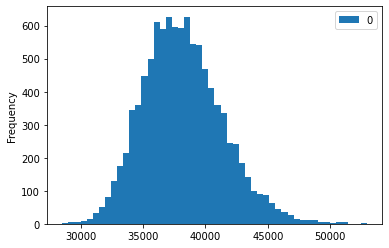

In [704]:
p, c = params[V_30s.sort_values(by=0).index[-1:]][0]
V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
print(f'Mean: {V_30.mean()[0]}, Median: {V_30.median()[0]}, Std: {V_30.std()[0]}, 1% Quantile: {emp_quantile(0.01, V_30)}')
V_30.plot.hist(bins=50)

In [ ]:
x,y = plot_emp_dist(V_30)

In [ ]:
pd.DataFrame(y, index = x).plot()

In [ ]:
V_30_rec = sample_V_rec(R1, years, sample_size,p, c, yearly_investment=1000)
print(f'Mean: {V_30_rec.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_rec)}')

In [ ]:
r_bar = 0.005

V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
#V_30_TI.plot.hist(bins=50)
print(f'Mean: {V_30_TI.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI)}')

In [ ]:
V_30_TI_rec = sample_V_TI_rec(R1, years, sample_size, r_bar)
#V_30_TI_rec.plot.hist(bins=50)
print(f'Mean: {V_30_TI_rec.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI_rec)}')

<AxesSubplot:ylabel='Frequency'>

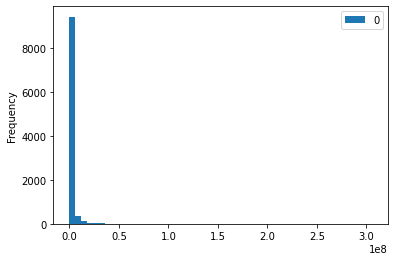

In [740]:
r_bar = 0.005
sample_lev = sample_V_lev(R1, years, sample_size, r_bar, leverage=3)
#print(f'Mean: {sample_lev.mean()[0]}, Median: {sample_lev.median()[0]}, 1% Quantile: {emp_quantile(0.01, sample_lev)}')
sample_lev.plot.hist(bins=50)

# Real World Data

In [741]:
data = yf.Ticker("SPY").history(period='MAX')
close = data['Close']
dim = 25
rets = close.pct_change(dim) + 1 # montly return
#rets = rets[dim:]
monthly_rets = rets[[dim*(i+1) for i in range(int(rets.shape[0]/dim))]]

In [742]:
months = 12 #Month in 30 years
sample_size = int(1e4)
yearly_historical = pd.DataFrame(np.random.choice(monthly_rets.values, size=(sample_size, months), replace=True)).prod(axis=1)

In [743]:
sample_size = int(1e4)
years = 30
R1 = pd.DataFrame(np.random.choice(yearly_historical.values, size=(sample_size, years), replace=True))

In [744]:
dives = 3
high = 1
low = 0
for d in range(dives):
    V_30s = []
    params = np.random.uniform(high = high, low = low, size=(10000,2))
    for p,c in params:    
        V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
        mean = V_30.mean()
        var = V_30.var()
        V_30s.append((mean - (C_/(2*V0))*var)[0])
        #V_30.plot.hist(bins=50)
    V_30s = pd.DataFrame(V_30s)
    high = params[V_30s.sort_values(by=0).index[-10:]].max(axis=0)
    low = params[V_30s.sort_values(by=0).index[-10:]].min(axis=0)

In [745]:
params[V_30s.sort_values(by=0).index[-1:]]

array([[0.36185665, 0.60470935]])

Mean: 57895.48900409595, Median: 0    57144.048882
dtype: float64, 1% Quantile: 69361.07725409322


<AxesSubplot:ylabel='Frequency'>

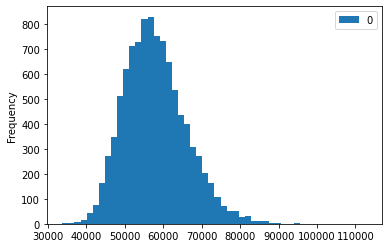

In [746]:
p, c = params[V_30s.sort_values(by=0).index[-1:]][0]
V_30 = sample_V(R1, years, sample_size, p, c, yearly_investment=1000)
print(f'Mean: {V_30.mean()[0]}, Median: {V_30.median()}, 1% Quantile: {emp_quantile(0.01, V_30)}')
V_30.plot.hist(bins=50)

Mean: 48091.073110655234, 1% Quantile: 69027.62037222121


<AxesSubplot:ylabel='Frequency'>

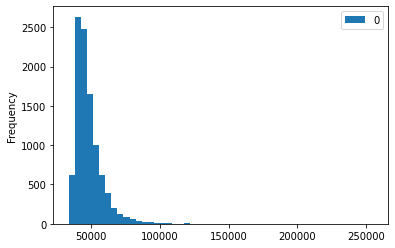

In [747]:
V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
print(f'Mean: {V_30_TI.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI)}')
V_30_TI.plot.hist(bins=50)

Mean: 1556163.4721548145, Median: 251562.7090974953, 1% Quantile: 5216311.62840714


<AxesSubplot:ylabel='Frequency'>

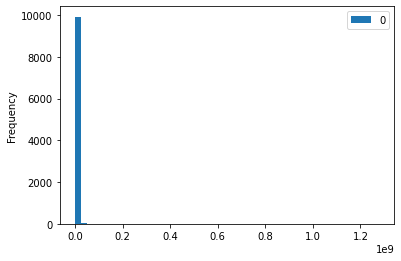

In [748]:
sample_lev = sample_V_lev(R1, years, sample_size, r_bar, leverage=3)
print(f'Mean: {sample_lev.mean()[0]}, Median: {sample_lev.median()[0]}, 1% Quantile: {emp_quantile(0.01, sample_lev)}')
sample_lev.plot.hist(bins=50)